In [1044]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf

# Weather data prediction (temperature for a single city)
## Example Data Science Project exploring:
- working with time series data for univariate and multivariate regression
- FC Networks and LSTMs
- Decision Trees and Random Forest
- sklearn and keras
- including categorical variables

### Open Questions/ Todos
- can we improve by including wind, pressure and humidiy?
- the splits for the LSTM models are still a bit hard to understand, see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array
- validation performance is better than train for some cases -> underfitting?
- consider State Space Models such as ARIMA, see https://www.statsmodels.org/dev/statespace.html

### References:
- data: https://www.kaggle.com/selfishgene/historical-hourly-weather-data
- https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/timeseries/ipynb/timeseries_weather_forecasting.ipynb#scrollTo=8uIMTjEtRGUt
- https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
- Géron, Aurélien. "Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems". O'Reilly Media, 2019.

### 1. Frame the Problem and Look at the Big Picture
- is it supervised, unsupervised or RL? -> supervised, since we have labelled data
- is it classification, regression task or smth else? -> regression, since we're predicting a value; specifically, multiple regression since we use multiple features
- should you use batch learning or online learning? -> batch learning ok; not online learning since there is no continous flow of data coming into the system, also no need to adjust to changing data rapidly
#### 1.1. Select a Performance Measure
- Residual Mean Squared Error (RMSE): corresponds to Euclidean Norm, sensitive to outliers; higher weight for large errors
- Sum of Absolutes, i.e. Mean Absolute Error (MAE): Manhattan norm
#### 1.2. Check the Assumptions
- how is the output of your model going to be used?

## Get and Explore the Data

In [932]:
data_temperature = pd.read_csv("temperature.csv", parse_dates=["datetime"])

In [933]:
data_temperature.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


In [934]:
data_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 37 columns):
datetime             45253 non-null datetime64[ns]
Vancouver            44458 non-null float64
Portland             45252 non-null float64
San Francisco        44460 non-null float64
Seattle              45250 non-null float64
Los Angeles          45250 non-null float64
San Diego            45252 non-null float64
Las Vegas            45252 non-null float64
Phoenix              45250 non-null float64
Albuquerque          45252 non-null float64
Denver               45252 non-null float64
San Antonio          45252 non-null float64
Dallas               45249 non-null float64
Houston              45250 non-null float64
Kansas City          45252 non-null float64
Minneapolis          45240 non-null float64
Saint Louis          45252 non-null float64
Chicago              45250 non-null float64
Nashville            45251 non-null float64
Indianapolis         45246 non-null float64
Atla

In [935]:
# alternative for converting the datetime column to a datetime object
# (if we forgot to set the parsing strategy when loading the csv)
data_temperature["datetime"] = pd.to_datetime(data_temperature.datetime)

### Select data of a single city and rename the target column

In [1026]:
data_montreal = data_temperature[["Montreal","datetime"]]

In [1027]:
data_montreal = data_montreal.rename(columns={"Montreal":"temperature"})

### Convert to Celsius for more intuitive interpretation

In [1028]:
data_montreal["temperature"] = data_montreal["temperature"] - 273.15

In [1029]:
data_montreal.dtypes

temperature           float64
datetime       datetime64[ns]
dtype: object

In [1030]:
data_montreal.shape

(45253, 2)

In [1031]:
data_montreal.head(3)

,temperature,datetime
0,NaN,2012-10-01 12:00:00
1,12.68000,2012-10-01 13:00:00
2,12.68465,2012-10-01 14:00:00


### Handle NAN values -> usually done separately on train and test
#### options:
- get rid of the row
- get rig of the whole attribute
- set the values to some value (e.g. mean, median, zero etc.)

In [1009]:
data_montreal_copy = data_montreal.copy(deep=True)
data_montreal_copy.dropna(subset=["temperature"]).head(3) # option 1
data_montreal_copy.drop("temperature", axis=1).head(3) # option 2, here makes no sense to drop the whole column
median = data_montreal_copy["temperature"].median() # option 3, note that we need to store the value to use
# use later on the test and validation data sets
data_montreal_copy["temperature"].fillna(median, inplace= True)
data_montreal_copy.head()

,temperature,datetime
0,7.959000,2012-10-01 12:00:00
1,12.680000,2012-10-01 13:00:00
2,12.684650,2012-10-01 14:00:00
3,12.697790,2012-10-01 15:00:00
4,12.710929,2012-10-01 16:00:00


#### option with sklearn: useful if we want to apply the same strategy to multiple columns

In [1010]:
from sklearn.impute import SimpleImputer

In [1011]:
imputer = SimpleImputer(strategy="median") # can be used only on numerical values!
data_montreal_num = data_montreal_copy.drop("datetime", axis=1)

In [1014]:
imputer.fit(data_montreal_num)
imputer.statistics_

array([7.959])

In [1015]:
X = imputer.transform(data_montreal_num)

In [1017]:
data_montreal_copy_tr = pd.DataFrame(X, columns=data_montreal_num.columns, 
                                    index = data_montreal_num.index)

In [1018]:
data_montreal_copy_tr.head(3)

,temperature
0,7.95900
1,12.68000
2,12.68465


### actual transform

In [1032]:
mean = data_montreal["temperature"].mean() 
data_montreal["temperature"].fillna(mean, inplace= True)
data_montreal.head()

,temperature,datetime
0,7.193010,2012-10-01 12:00:00
1,12.680000,2012-10-01 13:00:00
2,12.684650,2012-10-01 14:00:00
3,12.697790,2012-10-01 15:00:00
4,12.710929,2012-10-01 16:00:00


In [1033]:
data_montreal.shape

(45253, 2)

## Explore the numerical attributes values (here only temperature)

#### Things to consider:
- have the values been preprocessed?
- are the scales similar or very different?
- are the histograms "tail-heavy"?

In [947]:
data_montreal.temperature.describe()

count    45253.000000
mean         7.192744
std         11.953399
min        -29.850000
25%         -1.180000
50%          7.959000
75%         17.218333
max         34.730000
Name: temperature, dtype: float64

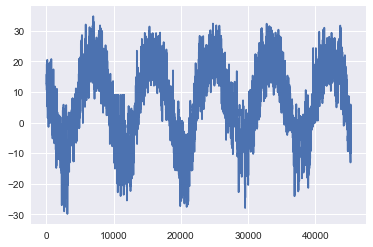

In [948]:
data_montreal.temperature.plot()

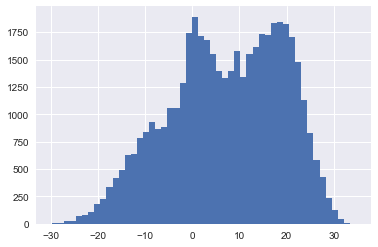

In [949]:
data_montreal.temperature.hist(bins=50)

/Users/sdoneva/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


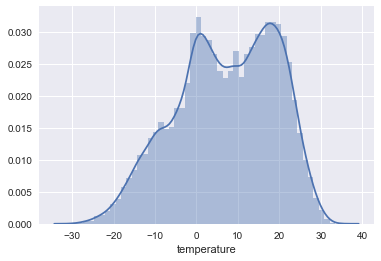

In [950]:
sns.distplot(data_montreal.temperature)

## Train/Test Data Split
- ensure that you use the same train and test set each time you ring the training
- two basic options: save after the split and load each time or set random_state 
- issue: train/test split not stable if you update the dataset
- advanced option: use the instance identifier to decide whether or not it should go to the test set, see function in the next cell

In [754]:
from zlib import crc32

- compute a hash value for each instance id 
- put that instance in the test set if the hash is lower than 20% of the maximum hash value
- ensures that the test set will remain consistent
- if you have no identifuer column, you can use the row index or the most stable feature (e.g. coordinates)

In [755]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier) & 0xffffffff < test_ratio *2**32)

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [688]:
from sklearn.model_selection import train_test_split

### note that due to the time series property, we don't use random shuffling before the split

In [689]:
#train_set, test_set = train_test_split(data_montreal, test_size=0.4, random_state = 42)
#valid_set, test_set = train_test_split(test_set, test_size=0.5, random_state = 42)

In [977]:
column_indices = {name: i for i, name in enumerate(data_montreal.columns)}

n = len(data_montreal)
train_set = data_montreal[0:int(n*0.7)].copy()
val_set = data_montreal[int(n*0.7):int(n*0.9)].copy()
test_set = data_montreal[int(n*0.9):].copy()

#num_features = data_montreal.shape[1]

In [968]:
train_set.head(2)

,temperature,datetime
0,12.68,2012-10-01 12:00:00
1,12.68,2012-10-01 13:00:00


## Discover and Visualize the Data to Gain Insights
- done on TRAIN set
#### Here 
- we experiment by using another of the datasets -> we explore how the mean temperature depends on the location
#### General
- compute standard correlation coefficients between every pair of attribute, e.g. df.corr() or scatter_matrix from pandas.plotting (NB! only linear combination is measured)
- experiment with attribute combinations -> get new attributes that are more correlated with our target

In [817]:
df_city_attributes = pd.read_csv("city_attributes.csv")

### first we compute the overall mean temperature per city

In [831]:
data_temperature_transposed = data_temperature.drop("datetime", axis=1).fillna(method = "bfill", axis=0).T.dropna(axis=1)

In [833]:
data_temperature_transposed['mean_temperature'] = data_temperature_transposed.mean(axis=1)

In [834]:
data_temperature_mean = data_temperature_transposed[['mean_temperature']] - 273.15

In [835]:
data_temperature_mean.reset_index(level=0, inplace=True)
data_temperature_mean = data_temperature_mean.rename(columns={"index":"City"})

In [836]:
data_temperature_mean.head()

,City,mean_temperature
0,Vancouver,10.712426
1,Portland,11.899524
2,San Francisco,15.005850
3,Seattle,11.323758
4,Los Angeles,17.691278


### now we can merge the temperature with the city attributes

In [837]:
df_city_attributes_and_temp = pd.merge(left=data_temperature_mean,
                                       right=df_city_attributes, left_on='City', right_on='City')

In [838]:
df_city_attributes_and_temp.head()

,City,mean_temperature,Country,Latitude,Longitude
0,Vancouver,10.712426,Canada,49.249660,-123.119339
1,Portland,11.899524,United States,45.523449,-122.676208
2,San Francisco,15.005850,United States,37.774929,-122.419418
3,Seattle,11.323758,United States,47.606209,-122.332069
4,Los Angeles,17.691278,United States,34.052231,-118.243683


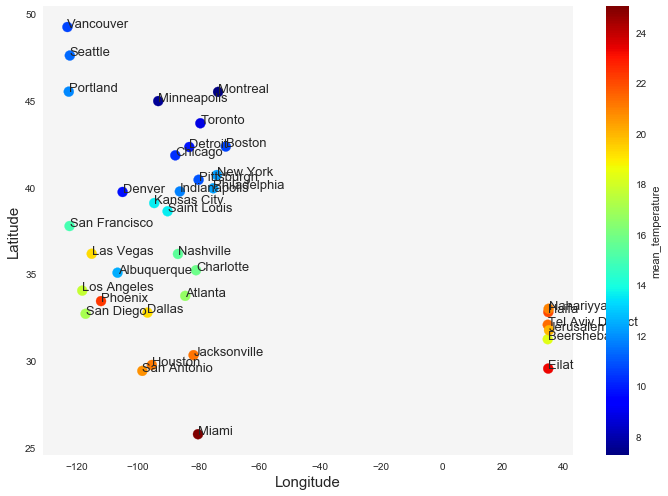

In [889]:
# note: important to set the axis in the plot, i.e. ax=ax, otherwise there are some issues with the plot annotations
fig, ax = plt.subplots()
df_city_attributes_and_temp.plot(kind="scatter", x = "Longitude", y= "Latitude", s=100,
                                 figsize=(10,7), c="mean_temperature", cmap=plt.get_cmap("jet"), ax=ax)
_ = df_city_attributes_and_temp[['Longitude','Latitude','City']].apply(lambda row: ax.text(*row, fontsize=13),axis=1)

ax.grid(False)
ax.set_facecolor('whitesmoke')
ax.set_ylabel("Latitude", size = 15)
ax.set_xlabel("Longitude", size = 15)
plt.tight_layout()


## Prepare the Data for ML algorithms
Note: Transofrmation pipelines and the treatment of text data is discussed later in the notebook

- here we encode the date time into cyclic features
- create two new features, deriving a sine transform and cosine transform
- see https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [981]:
train_set['hour'] = train_set.datetime.dt.hour
data_sampe = train_set[:48]

Text(0.5,1,'Hour feature before encoding')

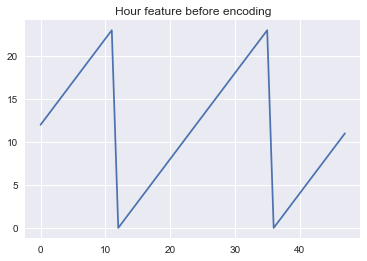

In [982]:
data_sampe["hour"].plot()
plt.title("Hour feature before encoding")

In [973]:
def encode(data, col, max_value):
    data[col + "_sin"] = np.sin(2*np.pi*data[col]/max_value)
    data[col + "_cos"] = np.cos(2*np.pi*data[col]/max_value)
    return data

In [989]:
# TODO: make all the changes related to the datetime column execute in a single function
# TODO: maybe write a custom transformer?

In [983]:
train_set = encode(train_set, "hour", 23)
train_set["month"] = train_set.datetime.dt.month
train_set = encode(train_set, "month", 12)
train_set["day"] = train_set.datetime.dt.day
train_set = encode(train_set, "day", 365)

In [984]:
val_set['hour'] = val_set.datetime.dt.hour
val_set = encode(val_set, "hour", 23)
val_set["month"] = val_set.datetime.dt.month
val_set = encode(val_set, "month", 12)
val_set["day"] = val_set.datetime.dt.day
val_set = encode(val_set, "day", 365)

In [987]:
test_set['hour'] = test_set.datetime.dt.hour
test_set = encode(test_set, "hour", 23)
test_set["month"] = test_set.datetime.dt.month
test_set = encode(test_set, "month", 12)
test_set["day"] = test_set.datetime.dt.day
test_set = encode(test_set, "day", 365)

In [985]:
train_set.head()

,temperature,datetime,hour,hour_sin,hour_cos,month,month_sin,month_cos,day,day_sin,day_cos
0,12.680000,2012-10-01 12:00:00,12,-0.136167,-0.990686,10,-0.866025,0.5,1,0.017213,0.999852
1,12.680000,2012-10-01 13:00:00,13,-0.398401,-0.917211,10,-0.866025,0.5,1,0.017213,0.999852
2,12.684650,2012-10-01 14:00:00,14,-0.631088,-0.775711,10,-0.866025,0.5,1,0.017213,0.999852
3,12.697790,2012-10-01 15:00:00,15,-0.816970,-0.576680,10,-0.866025,0.5,1,0.017213,0.999852
4,12.710929,2012-10-01 16:00:00,16,-0.942261,-0.334880,10,-0.866025,0.5,1,0.017213,0.999852


Text(0.5,1,'Hour signal after encoding')

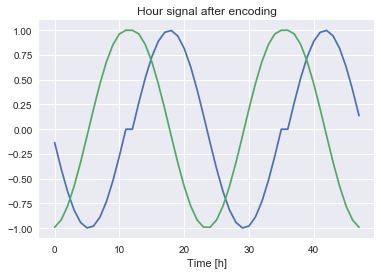

In [986]:
plt.plot(np.array(train_set['hour_sin'])[:48])
plt.plot(np.array(train_set['hour_cos'])[:48])
plt.xlabel('Time [h]')
plt.title('Hour signal after encoding')

## Select and Train a Model

### Dense NN for a single temperature value prediction

In [1046]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.optimizers import Adam

In [1047]:
def train_model(X_train, y_train, X_valid, y_valid, epochs):
    
    model = Sequential(
            [Dense(30, activation = "relu", input_shape=(X_train.shape[1],)),
             Dense(30, activation ="relu"),
             Dense(30, activation = "relu"),
             Dense(1, activation = "linear")])
    
    model.compile(optimizer = Adam(), loss = "mean_squared_error")
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))
    
    return model, history

In [1048]:
def get_unencoded_features(df):
    return df[["day","hour","month"]]

def get_encoded_features(df):
    return df[['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']]

#### Train without the sin/cos encoding of the date time features

In [1049]:
X_train = get_unencoded_features(train_set)
y_train = train_set.temperature

In [1050]:
X_valid = get_unencoded_features(valid_set)
y_valid = valid_set.temperature

In [1051]:
model, history = train_model(X_train, y_train, X_valid, y_valid, 50)

Epoch 1/50
990/990 [==============================] - 2s 2ms/step - loss: 99.8445 - val_loss: 71.3671
Epoch 2/50
990/990 [==============================] - 2s 2ms/step - loss: 51.3191 - val_loss: 36.7654
Epoch 3/50
990/990 [==============================] - 1s 1ms/step - loss: 35.4929 - val_loss: 30.6541
Epoch 4/50
990/990 [==============================] - 1s 2ms/step - loss: 32.3057 - val_loss: 29.9033
Epoch 5/50
990/990 [==============================] - 1s 1ms/step - loss: 31.4618 - val_loss: 29.5925
Epoch 6/50
990/990 [==============================] - 1s 1ms/step - loss: 30.6108 - val_loss: 29.9754
Epoch 7/50
990/990 [==============================] - 2s 2ms/step - loss: 30.2001 - val_loss: 27.5433
Epoch 8/50
990/990 [==============================] - 1s 1ms/step - loss: 29.9155 - val_loss: 29.9191
Epoch 9/50
990/990 [==============================] - 1s 1ms/step - loss: 29.8604 - val_loss: 28.1944
Epoch 10/50
990/990 [==============================] - 2s 2ms/step - loss: 29.6400

#### Train with the sin/cos encoding of the date time features

In [1052]:
X_train_enc = get_encoded_features(train_set)
X_valid_enc = get_encoded_features(valid_set)

In [1053]:
model_enc, history_enc = train_model(X_train_enc, y_train, X_valid_enc, y_valid, 50)

Epoch 1/50
990/990 [==============================] - 2s 2ms/step - loss: 41.7720 - val_loss: 27.3838
Epoch 2/50
990/990 [==============================] - 1s 1ms/step - loss: 28.4904 - val_loss: 26.8749
Epoch 3/50
990/990 [==============================] - 1s 1ms/step - loss: 28.0473 - val_loss: 26.5988
Epoch 4/50
990/990 [==============================] - 1s 1ms/step - loss: 27.9800 - val_loss: 26.3652
Epoch 5/50
990/990 [==============================] - 1s 1ms/step - loss: 27.8658 - val_loss: 26.5521
Epoch 6/50
990/990 [==============================] - 2s 2ms/step - loss: 27.8508 - val_loss: 26.4368
Epoch 7/50
990/990 [==============================] - 2s 2ms/step - loss: 27.8444 - val_loss: 26.4887
Epoch 8/50
990/990 [==============================] - 2s 2ms/step - loss: 27.8416 - val_loss: 26.4979
Epoch 9/50
990/990 [==============================] - 2s 2ms/step - loss: 27.7783 - val_loss: 26.3474
Epoch 10/50
990/990 [==============================] - 2s 2ms/step - loss: 27.7809

#### Compare Performances

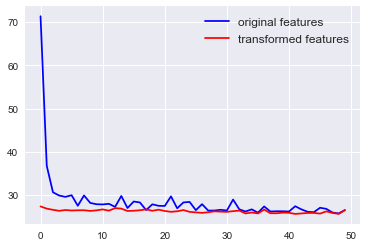

In [1054]:
plt.plot(history.history["val_loss"], c="b", label="original features")
plt.plot(history_enc.history["val_loss"], c="r", label="transformed features")
plt.legend(fontsize=12)

In [1055]:
X_test = get_unencoded_features(test_set)
X_test_enc = get_encoded_features(test_set)
y_test = test_set.temperature

In [1056]:
from sklearn.metrics import mean_squared_error as MSE

In [1057]:
mse = MSE(y_test, model.predict(X_test))
mse_enc = MSE(y_test, model_enc.predict(X_test_enc))

In [1058]:
print("Test MSE without {}, with {}".format(mse, mse_enc))

Test MSE without 19.979170401943364, with 21.13412520153671


Surprisingly the model trained with the unencoded time values performs better. TODO: more detailed evaluation.

### LSTM

In [177]:
from tensorflow import keras

In [1160]:
def get_montreal_data_encoded():
    data_montreal_enc = data_montreal.copy(deep=True)
    data_montreal_enc['hour'] = data_montreal_enc.datetime.dt.hour
    data_montreal_enc = encode(data_montreal_enc, "hour", 23)
    data_montreal_enc["month"] = data_montreal_enc.datetime.dt.month
    data_montreal_enc = encode(data_montreal_enc, "month", 12)
    data_montreal_enc["day"] = data_montreal_enc.datetime.dt.day
    data_montreal_enc = encode(data_montreal_enc, "day", 365)
    return data_montreal_enc

In [1063]:
# We will do some more sophisticated train/test splitting

data_montreal_enc = get_montreal_data_encoded()

df = get_encoded_features(data_montreal_enc)

In [1064]:
df.head()

,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,-0.866025,0.5,0.017213,0.999852,-0.136167,-0.990686
1,-0.866025,0.5,0.017213,0.999852,-0.398401,-0.917211
2,-0.866025,0.5,0.017213,0.999852,-0.631088,-0.775711
3,-0.866025,0.5,0.017213,0.999852,-0.816970,-0.576680
4,-0.866025,0.5,0.017213,0.999852,-0.942261,-0.334880


In [1065]:
df = pd.concat([df, data_montreal.temperature], axis=1)

In [1066]:
df.columns = list(range(7))

In [1067]:
df.head()

,0,1,2,3,4,5,6
0,-0.866025,0.5,0.017213,0.999852,-0.136167,-0.990686,7.193010
1,-0.866025,0.5,0.017213,0.999852,-0.398401,-0.917211,12.680000
2,-0.866025,0.5,0.017213,0.999852,-0.631088,-0.775711,12.684650
3,-0.866025,0.5,0.017213,0.999852,-0.816970,-0.576680,12.697790
4,-0.866025,0.5,0.017213,0.999852,-0.942261,-0.334880,12.710929


#### Idea: using the temperature data from the last 72 hours, predict what the temperature will be in 24 hours. 

In [1105]:
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 72
future = 24
learning_rate = 0.002
batch_size = 125
epochs = 15

In [1106]:
train_data = df.loc[0 : train_split - 1]
val_data = df.loc[train_split:]

In [1107]:
train_data.shape, val_data.shape

((31677, 7), (13576, 7))

In [1108]:
# prep train data
start = past + future # labels start at 96
end = start + train_split # end at 31773

x_train = train_data[[i for i in range(7)]].values 
y_train = df.iloc[start:end][[6]] # temperature values

In [1109]:
x_train.shape, y_train.shape

((31677, 7), (31677, 1))

In [1110]:
# prer validation data
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = df.iloc[label_start:][[6]]

In [1111]:
x_val.shape

(13480, 7)

In [1112]:
sequence_length = int(past / step)
sequence_length

72

In [1113]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length, # how many steps will you use to make the prediction
    sampling_rate=step, # if you want to pick only every 2nd or 6th element from the data
    batch_size=batch_size
)

In [1114]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (125, 72, 7)
Target shape: (125, 1)


In [1115]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 72, 7)]           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                5120      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [1116]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val
)

Epoch 1/15
253/253 [==============================] - 16s 62ms/step - loss: 97.8040 - val_loss: 56.7885
Epoch 2/15
253/253 [==============================] - 15s 61ms/step - loss: 38.1401 - val_loss: 33.1308
Epoch 3/15
253/253 [==============================] - 15s 61ms/step - loss: 27.4221 - val_loss: 23.8723
Epoch 4/15
253/253 [==============================] - 15s 60ms/step - loss: 25.1352 - val_loss: 23.7524
Epoch 5/15
253/253 [==============================] - 15s 61ms/step - loss: 23.4993 - val_loss: 18.7850
Epoch 6/15
253/253 [==============================] - 15s 61ms/step - loss: 22.5073 - val_loss: 18.3788
Epoch 7/15
253/253 [==============================] - 15s 60ms/step - loss: 21.9539 - val_loss: 17.8656
Epoch 8/15
253/253 [==============================] - 15s 61ms/step - loss: 21.6990 - val_loss: 17.6033
Epoch 9/15
253/253 [==============================] - 15s 60ms/step - loss: 21.3135 - val_loss: 17.3482
Epoch 10/15
253/253 [==============================] - 15s 60ms/

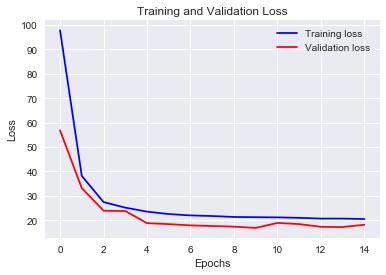

In [1117]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

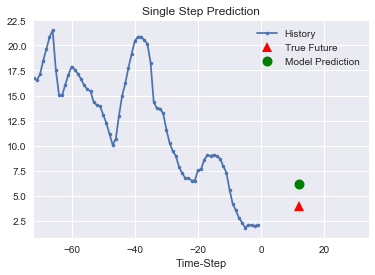

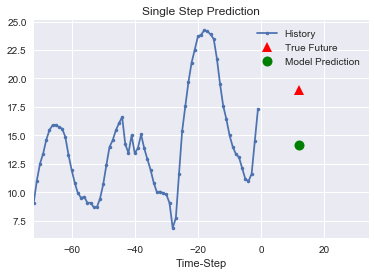

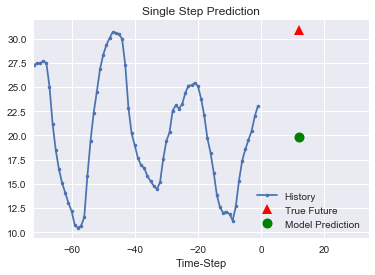

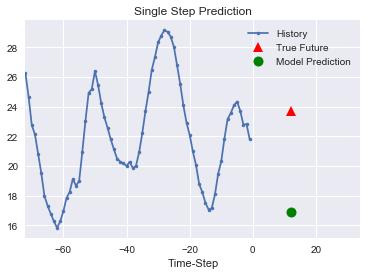

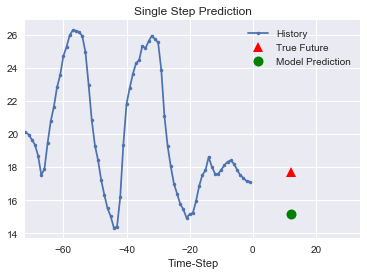

In [1118]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "r^", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

# TODO TEST SET !
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 6].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

### Multi-steps ahead

Below we experiment with predicting multiple steps in the future. In the previous example every train sequence of 72 hours was associated with a single target point 24h ahead. Here every train sequence is associated with a target sequence representing the next 24 hours.

In [1095]:
y_train_multi = []

target_size = 24
start_index = 96 # where labels will start
end_index = len(y_train) - target_size

for i in range(0, end_index):
    y_train_multi.append(y_train[i:i+target_size].values)

y_train_multi = np.array(y_train_multi).squeeze() # target is a list of labels

x_train_multi = x_train[:len(x_train)-target_size] # train data up to the last starting point of the targets

dataset_train_multistep = keras.preprocessing.timeseries_dataset_from_array(
    x_train_multi,
    y_train_multi,
    sequence_length=72,
    sampling_rate=step,
    batch_size=batch_size,
)
for batch in dataset_train_multistep.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (125, 72, 7)
Target shape: (125, 24)


In [1096]:
y_val_multi = []

target_size = 24
start_index = 96
end_index = len(y_val) - target_size

for i in range(0, end_index):

    y_val_multi.append(y_val[i:i+target_size].values)

y_val_multi = np.array(y_val_multi).squeeze()
x_val_multi = x_val[:len(x_val)-target_size]
y_val_multi.shape, x_val_multi.shape

dataset_val_multistep = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val_multi,
    y_val_multi,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [1097]:
lstm_model_multi = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=target_size)
])

In [1098]:
lstm_model_multi.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

history = lstm_model_multi.fit(dataset_train_multistep, epochs=25,
                      validation_data=dataset_val_multistep)

Epoch 1/25

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

253/253 [==============================] - 16s 63ms/step - loss: 138.6471 - mean_absolute_error: 9.6202 - val_loss: 108.2751 - val_mean_absolute_error: 8.6208
Epoch 2/25
253/253 [==============================] - 16s 63ms/step - loss: 77.7088 - mean_absolute_error: 7.1816 - val_loss: 59.7786 - val_mean_absolute_error: 6.3444
Epoch 3/25
253/253 [==============================] - 15s 61ms/step - loss: 53.3244 - mean_absolute_error: 5.9271 - val_loss: 40.2064 - val_mean_absolute_error: 5.1541
Ep

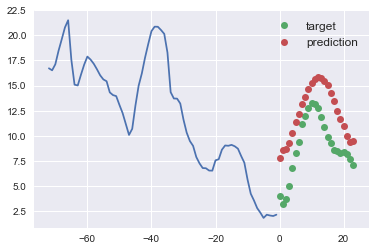

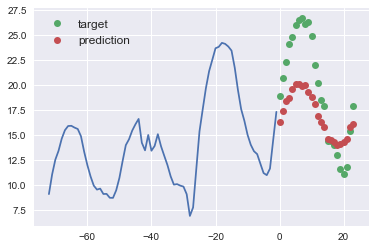

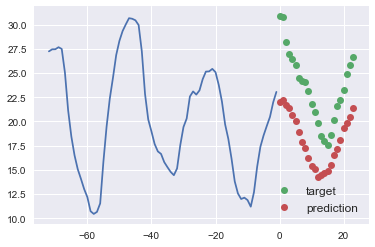

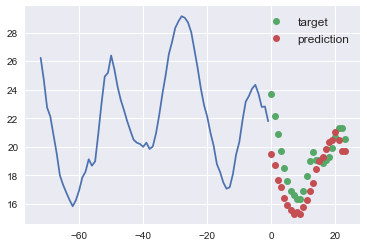

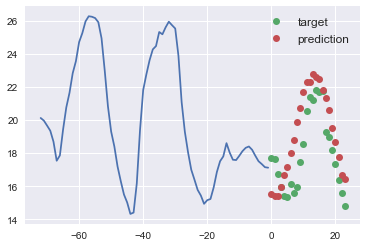

In [1104]:
for x, y in dataset_val_multistep.take(5):
    print()
    data = x[0][:, 6].numpy()
    #print("target" , y[0].numpy())
    #print("pred ",lstm_model_multi.predict(x)[0])
    time_steps = list(range(-(data.shape[0]), 0))
    future = list(range(0,target_size))
    plt.plot(time_steps, x[0][:, 6].numpy())
    plt.plot(future, y[0].numpy(), 'o', label="target")
    plt.plot(future, lstm_model_multi.predict(x)[0], 'o', label="prediction")
    plt.legend(fontsize=12)
    plt.show()

## Decision Tree and Random Forest Regression 
- including parameter fine tuning
- Note: if you have large hyperparameters space, use Randomised Search.

In [1122]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [1123]:
X_train.head()

,day,hour,month
0,1,12,10
1,1,13,10
2,1,14,10
3,1,15,10
4,1,16,10


In [1124]:
X_train_enc.head()

,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,-0.866025,0.5,0.017213,0.999852,-0.136167,-0.990686
1,-0.866025,0.5,0.017213,0.999852,-0.398401,-0.917211
2,-0.866025,0.5,0.017213,0.999852,-0.631088,-0.775711
3,-0.866025,0.5,0.017213,0.999852,-0.816970,-0.576680
4,-0.866025,0.5,0.017213,0.999852,-0.942261,-0.334880


In [1144]:
param_grid = [{'min_samples_leaf': [20,30,40,50,60], 'max_depth':[5,7,8,10,15,20,25]}]   

grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 7, 'min_samples_leaf': 60}

In [1135]:
tree_model = DecisionTreeRegressor(min_samples_leaf=grid_search.best_params_['min_samples_leaf'], max_depth=grid_search.best_params_['max_depth'])
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=60)

#### Check on feature importance

In [1136]:
for feature, weight in zip(list(X_train.columns), tree_model.feature_importances_):
    print("{} weights {}".format(feature, weight))

day weights 0.043196579529984645
hour weights 0.031301281174108846
month weights 0.9255021392959065


In [1146]:
param_grid = [{'min_samples_leaf': [10,20,30], 'max_depth': [30,40,50,70],
              'n_estimators': [100, 200, 300]}]   

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train.values.ravel()) # https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
grid_search.best_params_
grid_search.best_params_

{'max_depth': 70, 'min_samples_leaf': 30, 'n_estimators': 100}

In [1148]:
rf_model = RandomForestRegressor(max_depth= 70, min_samples_leaf = 30, n_estimators= 100)
rf_model.fit(X_train, y_train)

/Users/sdoneva/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=70, min_samples_leaf=30)

#### predictions on test data

In [1149]:
mse_tree = MSE(y_test, tree_model.predict(X_test))
mse_forest = MSE(y_test, rf_model.predict(X_test))

In [1150]:
mse_tree, mse_forest

(21.35094664203046, 22.037530807117474)

## Using weather description data

In [1151]:
from sklearn.preprocessing import OneHotEncoder

In [1152]:
data_weather_description = pd.read_csv("weather_description.csv", parse_dates=["datetime"])
data_weather_description.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,haze,NaN,NaN,NaN
1,2012-10-01 13:00:00,mist,scattered clouds,light rain,sky is clear,mist,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,overcast clouds,sky is clear,sky is clear,sky is clear,haze,sky is clear,sky is clear,sky is clear
2,2012-10-01 14:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,sky is clear,sky is clear,broken clouds,overcast clouds,sky is clear,overcast clouds
3,2012-10-01 15:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds
4,2012-10-01 16:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds


In [1153]:
data_weather_description["Montreal"].isna().sum(), data_weather_description["Montreal"].nunique()

(1, 37)

In [1154]:
data_weather_description["Montreal"].value_counts()

broken clouds                   8151
sky is clear                    7299
overcast clouds                 6637
few clouds                      6317
light rain                      4015
scattered clouds                3407
mist                            3196
light snow                      1796
light intensity shower rain     1067
moderate rain                    770
heavy snow                       536
fog                              456
light shower snow                331
proximity shower rain            281
snow                             175
haze                             171
heavy intensity rain             168
heavy shower snow                119
light intensity drizzle          117
thunderstorm with light rain      69
proximity thunderstorm            39
thunderstorm                      31
smoke                             18
thunderstorm with rain            16
light intensity drizzle rain      14
shower rain                       11
light shower sleet                 9
l

In [1155]:
data_montreal_description = data_weather_description[["Montreal", "datetime"]]

In [1156]:
data_montreal_description = data_montreal_description.fillna(method = "bfill", axis=0).dropna()

In [1157]:
data_montreal_description = data_montreal_description.rename(columns={"Montreal":"description"})

In [1158]:
data_montreal_description.head(2)

,description,datetime
0,overcast clouds,2012-10-01 12:00:00
1,overcast clouds,2012-10-01 13:00:00


In [1161]:
data_montreal_enc = get_montreal_data_encoded()
data_montreal_enc.head()

,temperature,datetime,hour,hour_sin,hour_cos,month,month_sin,month_cos,day,day_sin,day_cos
0,7.193010,2012-10-01 12:00:00,12,-0.136167,-0.990686,10,-0.866025,0.5,1,0.017213,0.999852
1,12.680000,2012-10-01 13:00:00,13,-0.398401,-0.917211,10,-0.866025,0.5,1,0.017213,0.999852
2,12.684650,2012-10-01 14:00:00,14,-0.631088,-0.775711,10,-0.866025,0.5,1,0.017213,0.999852
3,12.697790,2012-10-01 15:00:00,15,-0.816970,-0.576680,10,-0.866025,0.5,1,0.017213,0.999852
4,12.710929,2012-10-01 16:00:00,16,-0.942261,-0.334880,10,-0.866025,0.5,1,0.017213,0.999852


In [1166]:
data_montreal_description.shape, data_montreal_enc.shape

((45253, 2), (45253, 11))

In [1167]:
data_montreal_with_descr = pd.concat([data_montreal_description, data_montreal_enc], axis=1)

In [1168]:
data_montreal_with_descr.head()

,description,datetime,temperature,datetime,hour,hour_sin,hour_cos,month,month_sin,month_cos,day,day_sin,day_cos
0,overcast clouds,2012-10-01 12:00:00,7.193010,2012-10-01 12:00:00,12,-0.136167,-0.990686,10,-0.866025,0.5,1,0.017213,0.999852
1,overcast clouds,2012-10-01 13:00:00,12.680000,2012-10-01 13:00:00,13,-0.398401,-0.917211,10,-0.866025,0.5,1,0.017213,0.999852
2,sky is clear,2012-10-01 14:00:00,12.684650,2012-10-01 14:00:00,14,-0.631088,-0.775711,10,-0.866025,0.5,1,0.017213,0.999852
3,sky is clear,2012-10-01 15:00:00,12.697790,2012-10-01 15:00:00,15,-0.816970,-0.576680,10,-0.866025,0.5,1,0.017213,0.999852
4,sky is clear,2012-10-01 16:00:00,12.710929,2012-10-01 16:00:00,16,-0.942261,-0.334880,10,-0.866025,0.5,1,0.017213,0.999852


In [1169]:
train_set, test_set = train_test_split(data_montreal_with_descr, test_size=0.4)
valid_set, test_set = train_test_split(test_set, test_size=0.5)

In [1170]:
def get_relevant_features(df):
    return df[["day","hour","month", "description"]]

In [1171]:
X_train_not_enc = get_relevant_features(train_set)
X_valid_not_enc = get_relevant_features(valid_set)
X_test_not_enc = get_relevant_features(test_set)

In [1172]:
y_train = train_set["temperature"]
y_valid = valid_set["temperature"]
y_test = test_set["temperature"]

In [1173]:
X_train_not_enc.head()

,day,hour,month,description
4449,4,21,4,overcast clouds
20503,2,19,2,overcast clouds
7844,24,8,8,sky is clear
6206,17,2,6,few clouds
8087,3,11,9,light rain


In [1174]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(X_train_not_enc)

OneHotEncoder(handle_unknown='ignore')

In [1175]:
feature_names = list(X_train_not_enc["description"].unique())
len(feature_names)

36

In [1176]:
X_object = X_train_not_enc.description.values.reshape(-1,1)

In [1177]:
X_test_obj = X_test_not_enc.description.values.reshape(-1,1)

In [1178]:
ohe.fit(X_object)

OneHotEncoder(handle_unknown='ignore')

In [1179]:
codes = ohe.transform(X_object).toarray()

In [1180]:
codes_test = ohe.transform(X_test_obj).toarray()

In [1181]:
enc_descriptions = pd.DataFrame(codes, columns=feature_names).astype(int)
enc_descriptions_test = pd.DataFrame(codes_test, columns=feature_names).astype(int)

In [1182]:
enc_descriptions_test.head()

,overcast clouds,sky is clear,few clouds,light rain,broken clouds,scattered clouds,heavy snow,haze,light intensity shower rain,mist,...,smoke,shower snow,dust,thunderstorm,thunderstorm with heavy rain,very heavy rain,sand,light intensity drizzle rain,heavy intensity shower rain,freezing rain
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1183]:
#feature_names = ohe.get_feature_names(feature_names)

In [1184]:
X_train_not_enc.reset_index(drop=True, inplace=True)
enc_descriptions.reset_index(drop=True, inplace=True)

In [1185]:
#feature_names = ohe.get_feature_names(feature_names)
X_train_hot_encoded = pd.concat([X_train_not_enc, enc_descriptions], axis=1)
X_train_hot_encoded = X_train_hot_encoded.drop("description", axis=1)

In [1186]:
X_train_hot_encoded.head()

,day,hour,month,overcast clouds,sky is clear,few clouds,light rain,broken clouds,scattered clouds,heavy snow,...,smoke,shower snow,dust,thunderstorm,thunderstorm with heavy rain,very heavy rain,sand,light intensity drizzle rain,heavy intensity shower rain,freezing rain
0,4,21,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,19,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,8,8,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,17,2,6,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,11,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1187]:
X_test_not_enc.reset_index(drop=True, inplace=True)
enc_descriptions_test.reset_index(drop=True, inplace=True)

X_test_hot_encoded = pd.concat([X_test_not_enc, enc_descriptions_test], axis=1)
X_test_hot_encoded = X_test_hot_encoded.drop("description", axis=1)

In [1188]:
X_test_hot_encoded.head()

,day,hour,month,overcast clouds,sky is clear,few clouds,light rain,broken clouds,scattered clouds,heavy snow,...,smoke,shower snow,dust,thunderstorm,thunderstorm with heavy rain,very heavy rain,sand,light intensity drizzle rain,heavy intensity shower rain,freezing rain
0,2,22,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27,17,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,10,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,9,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,7,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1189]:
param_grid = [{'min_samples_leaf': [5, 10,20,30], 'max_depth':[15,20,25,35,45,50]}]   

grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
grid_search.fit(X_train_hot_encoded, y_train)
grid_search.best_params_

{'max_depth': 15, 'min_samples_leaf': 10}

In [1190]:
dec_tree_model = DecisionTreeRegressor(min_samples_leaf=10, max_depth=15)
dec_tree_model.fit(X_train_hot_encoded, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=10)

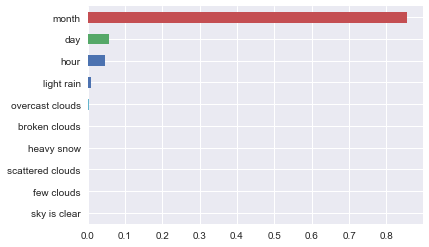

In [1191]:
coef = pd.Series(dec_tree_model.feature_importances_[:10], index = X_train_hot_encoded.columns[:10])
imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")

In [1192]:
for importance, name in sorted(zip(dec_tree_model.feature_importances_, X_train_hot_encoded.columns),reverse=True)[:7]:
    print (name, importance)

month 0.8540727947701983
day 0.056651914270165145
hour 0.045136769388770516
dust 0.014276655465798229
light rain 0.008945975885200496
light shower snow 0.004292964930742187
overcast clouds 0.0037122266176288095


In [1193]:
MSE(y_test, dec_tree_model.predict(X_test_hot_encoded))

19.268817974644026

In [1194]:
param_grid_rf = [{'min_samples_leaf': [5,10,15], 'max_depth':[40,50,60,70], 'n_estimators':[300,400,500]}]
grid_search = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5)
grid_search.fit(X_train_hot_encoded, y_train)
grid_search.best_params_

{'max_depth': 60, 'min_samples_leaf': 5, 'n_estimators': 400}

In [1197]:
rf_model = RandomForestRegressor(min_samples_leaf=5, max_depth=60, n_estimators=400)
rf_model.fit(X_train_hot_encoded, y_train)

RandomForestRegressor(max_depth=60, min_samples_leaf=5, n_estimators=400)

In [1198]:
MSE(y_test, rf_model.predict(X_test_hot_encoded))

16.808063177131807

### Testing encoding pipelines
- here we experiment with pre-processing functionalities of sklearn

In [1203]:
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [1204]:
X_train_not_enc.head()

,day,hour,month,description
0,4,21,4,overcast clouds
1,2,19,2,overcast clouds
2,24,8,8,sky is clear
3,17,2,6,few clouds
4,3,11,9,light rain


In [1205]:
categorical_columns = ['description']
numerical_columns = ['hour'] # taking hour just as a sample

In [1206]:
num_pipeline = Pipeline([
                        ("imputer", SimpleImputer(strategy="mean")),
                        ("std_scaler", StandardScaler())
])

In [1218]:
full_preprocessor_pipeline = ColumnTransformer([
                            ("cat", OneHotEncoder(handle_unknown = 'ignore'), categorical_columns),
                            ("num", num_pipeline, numerical_columns)], 
                            remainder='passthrough')

In [1219]:
#, handle_unknown = 'ignore', drop='if_binary'

In [639]:
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore', dtype=int), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)

In [1220]:
X_train_enc_test = full_preprocessor_pipeline.fit_transform(X_train_not_enc).toarray()

In [1221]:
feature_names[:5], len(feature_names)

(['overcast clouds',
  'sky is clear',
  'few clouds',
  'light rain',
  'broken clouds'],
 36)

In [1222]:
all_features = feature_names + ["hour", "day", "month"]

In [1223]:
df_pipeline_results = pd.DataFrame(X_train_enc_test, columns = all_features)#.astype(int)

In [1224]:
df_pipeline_results.head()

,overcast clouds,sky is clear,few clouds,light rain,broken clouds,scattered clouds,heavy snow,haze,light intensity shower rain,mist,...,thunderstorm,thunderstorm with heavy rain,very heavy rain,sand,light intensity drizzle rain,heavy intensity shower rain,freezing rain,hour,day,month
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.379288,4.0,4.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.089689,2.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.503105,24.0,8.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.371902,17.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.068707,3.0,9.0


In [1225]:
X_test_not_enc.head(2)

,day,hour,month,description
0,2,22,8,broken clouds
1,27,17,6,broken clouds


In [1226]:
X_test_enc_test = full_preprocessor_pipeline.transform(X_test_not_enc).toarray()

In [1227]:
df_pipeline_results_test_data = pd.DataFrame(X_test_enc_test, columns = all_features)

In [1228]:
df_pipeline_results_test_data.head()

,overcast clouds,sky is clear,few clouds,light rain,broken clouds,scattered clouds,heavy snow,haze,light intensity shower rain,mist,...,thunderstorm,thunderstorm with heavy rain,very heavy rain,sand,light intensity drizzle rain,heavy intensity shower rain,freezing rain,hour,day,month
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.524088,2.0,8.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800090,27.0,6.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.213506,1.0,11.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.358306,16.0,7.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.647905,17.0,1.0
